In [85]:
import pandas as pd
import numpy as np
import os
import time
import librosa
import librosa.display
import matplotlib.pyplot as plt
from pydub import AudioSegment
from scipy.ndimage import zoom
from keras.applications import VGG16
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import cv2 as cv
from keras import layers, models, Model
from keras.optimizers import Adam
import tensorflow as tf

In [68]:
def create_spectrogram(wav_path, sr=16000):

    y, sr = librosa.load(wav_path)

    # Create mel spectrogram
    mel_spect = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_mels=128,  # Number of mel bands
        fmax=8000    # Maximum frequency
    )

    # Convert to log scale and return
    return np.array(librosa.power_to_db(mel_spect, ref=np.max))

wav_path = '../raw_data/test/0_4753_4846_OffMenu263.wav'
spectrogram = create_spectrogram(wav_path)
spectrogram.shape

(128, 216)

In [69]:
def resize_spectrogram(spectrogram, output_size):
    sp_row, sp_col = spectrogram.shape
    out_row, out_col = output_size
    resized_spec = zoom(spectrogram, (out_row/sp_row, out_col/sp_col))
    return resized_spec

In [70]:
def minmax_scaler(spectrogram):
    min_val = np.min(spectrogram)
    max_val = np.max(spectrogram)

    normalised_spectrogram = (spectrogram - min_val) / (max_val - min_val)

    return normalised_spectrogram

In [71]:
def reshape_spectrogram(spectrogram):
    temp_spectogrram =  np.stack((spectrogram, spectrogram, spectrogram), axis=2)
    return temp_spectogrram

In [77]:
# Function to loop through all clip files and generate spectrograms
def get_features_model (folder_path):
    spectrograms = [] # This will store the spectrograms of each clip
    labels = []  # This will store the labels of each clip
    seconds = []  # Number of seconds to consider for each clip
    durations = []  # Duration of the full audio file
    podcast_names = []  # This will store the podcast names of each clip

    # Iterate over all files in the directory
    file_list = os.listdir(folder_path)
    print(f"Processing files: total {len(file_list)}")
    for filename in file_list:
        # Check if the file is a .wav or .mp3 (you can adjust this as needed)
        if filename.endswith('.wav') or filename.endswith('.mp3'):
            file_path = os.path.join(folder_path, filename)

            # Split the filename by underscore
            filename_parts = filename.split('_')

            # Extract 0 or 1 from the first part of the filename (label: ad or no_ad)
            is_ad = int(filename_parts[0])  # First part is the label

            # Extract the start time in seconds (second part of the filename)
            start_time = int(filename_parts[1])  # Second part is the start time in seconds

            # Extract the total duration (third part of the filename)
            duration = int(filename_parts[2])  # Third part is the total duration of the podcast

             # Extract the podcast name (four part of the filename)
            podcast_name = filename_parts[3].replace('.wav', '')  # Third part is the total duration of the podcast

            # Create spectrogram and convert to numpy array
            spectrogram = create_spectrogram(file_path)
            resized_spectrogram =resize_spectrogram(spectrogram, (224,224))
            scaled_spectrogram = minmax_scaler(resized_spectrogram)
            reshaped_spectrogram = reshape_spectrogram(scaled_spectrogram)

            # Append the numpy array to the list
            spectrograms.append(reshaped_spectrogram)
            labels.append(is_ad)
            seconds.append(start_time)
            durations.append(duration)
            podcast_names.append(podcast_name)

    return spectrograms, labels, seconds, durations, podcast_names

In [78]:
# Data folder path: Change this to the path where your audio clips are stored
folder_path = '../raw_data/OffMenu263'
all_spectrograms = get_features_model(folder_path)

Processing files: total 4800


In [79]:
X = np.array(all_spectrograms[0])
y = np.array(all_spectrograms[1])

In [80]:
print(X.shape)
print(y.shape)

(4800, 224, 224, 3)
(4800,)


In [81]:
X_train, X_test, y_train, y_test = train_test_split(np.array(X), y, test_size=0.2, random_state=42)

(128, 216)

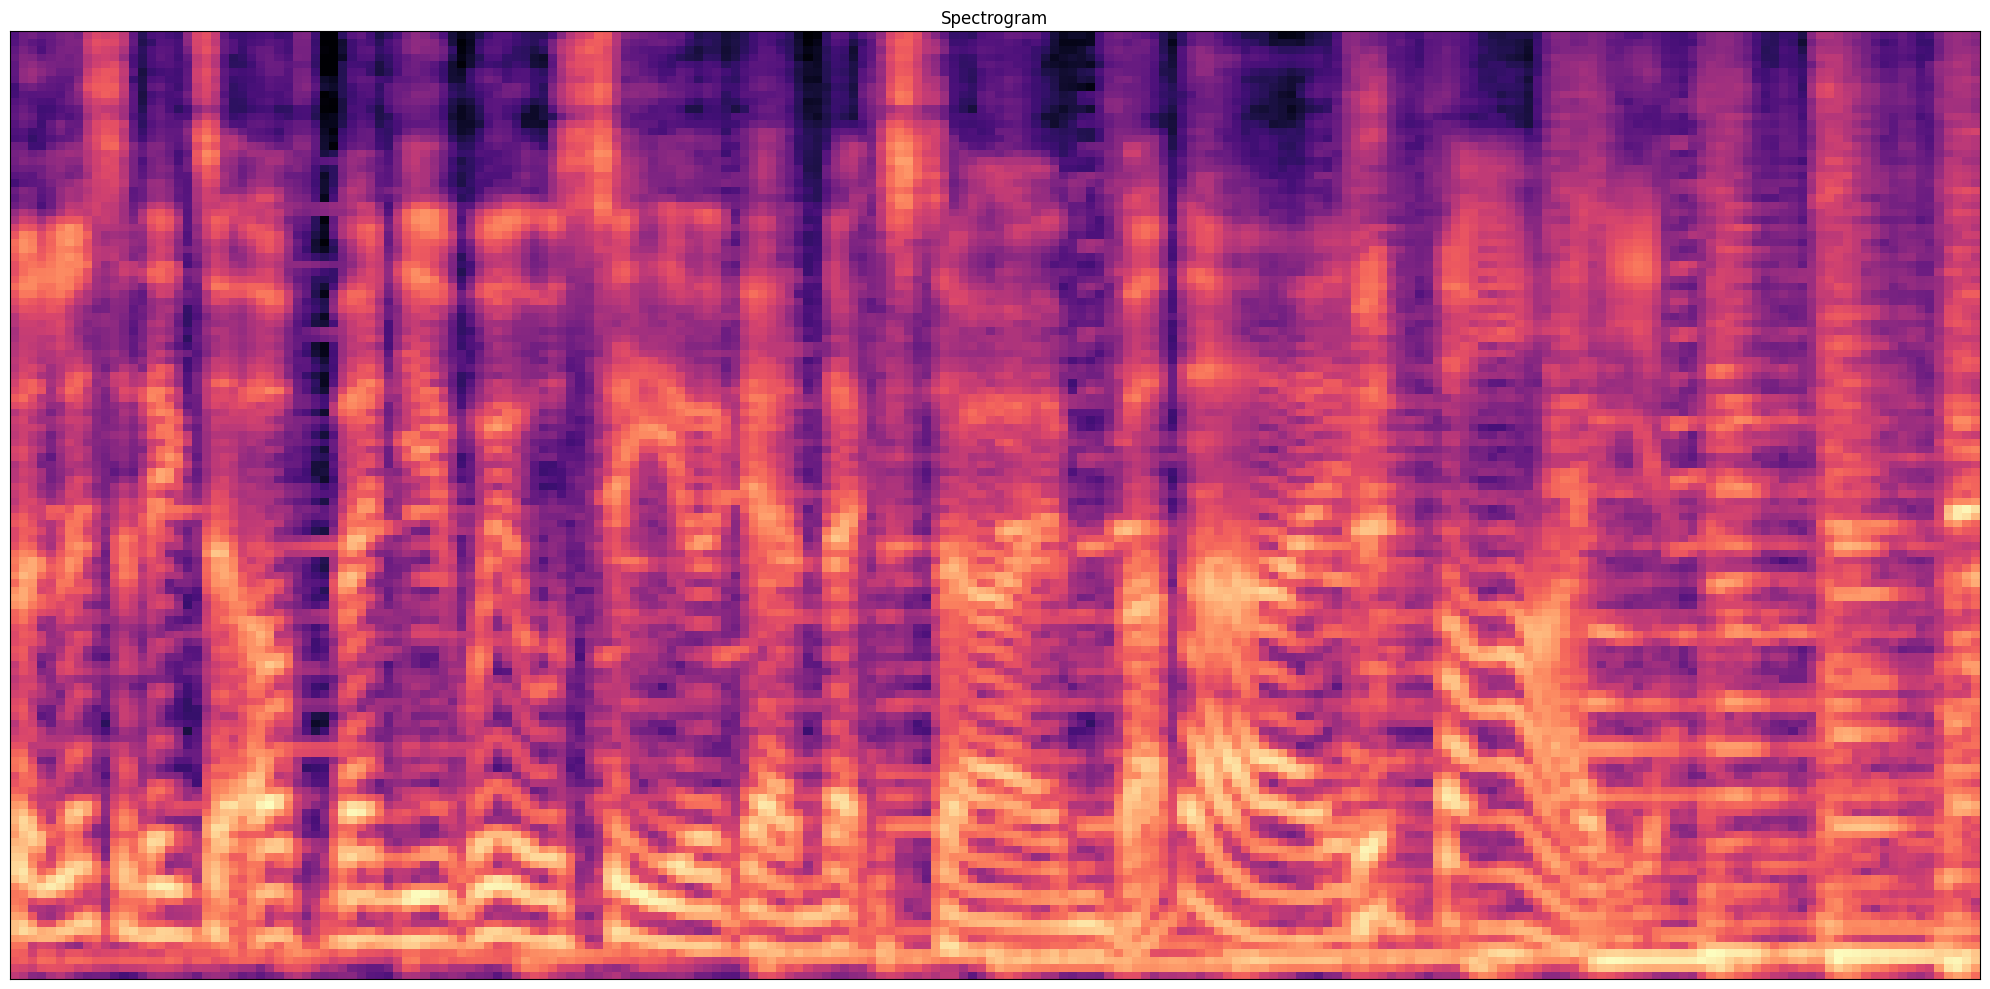

In [82]:
def plot_spectrogram(spectrogram_db, sr, hop_length):
    plt.figure(figsize=(20, 10))
    librosa.display.specshow(spectrogram_db, sr=sr, hop_length=hop_length)
    plt.title('Spectrogram')
    plt.tight_layout()
    # plt.savefig(output_path)
    # plt.close()
plot_spectrogram(spectrogram, 16000, 1)
spectrogram.shape

# VGG-16 Model
# Import VGG16 and set the necessary arguments:

In [88]:
def build_baseline_model(input_shape=(224,224,3), freeze_base=True):
    base_model = tf.keras.applications.VGG16(
        include_top=False,
        input_shape=input_shape,
        weights=None)
    base_model.trainable = freeze_base
    x = base_model.output

    #flatten
    x = layers.Flatten()(x)

    #dense layer for ad detection
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    #output layer for ad detection
    output = layers.Dense(1, activation='sigmoid')(x)
    loss = 'binary_crossentropy'

    #create
    model = models.Model(
        inputs=base_model.input,
        outputs=output
    )

    #compile
    model.compile(
        loss=loss,
        optimizer='adam',
        metrics=['accuracy']
    )
    return model

In [89]:
model = build_baseline_model(
    input_shape=(224,224,3),
    freeze_base=True
)

In [ ]:
history = model.fit(
    X_train,
    y_train,
    batch_size=16,
    epochs=2,
    validation_data=(X_test,y_test)
)

Epoch 1/2
154/240 ━━━━━━━━━━━━━━━━━━━━ 10:13 7s/step - accuracy: 0.8888 - loss: 0.3596

In [ ]:
def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = range(1, len(loss) + 1)

    plt.figure(figsize=(12,5))

    #loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'ro-', label='Valisation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

plot_history(history)